# Support Vector Machine

## About the algorithm

Support vector machine or SVM is another one of the most widely used algorithms for classification. It is one of the most high-performing algorithms with a little amount of tuning. It uses a Maximal-Margin classifier under the hood which constructs a hyperplane to split the space of the independent variables into the target variable classes. The distance between the hyperplane and the closest data points is referred to as the margin. The hyperplane is considered to be best when this distance is the largest. The closest points known as support vectors are considered relevant for defining the classifiers. The job of the optimization algorithm is to maximize the margin between the hyperplane and support vectors {cite}`brownlee_2020_svm`.

In [93]:
# Import necessary packages
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 800
svg_renderer.height = 500
pio.renderers.default = "svg"

The same procedure as that followed for the logistic regression will be followed for the support vector machine.

## Model without oversample data

In [2]:
# Load the data
df = pd.read_csv('./../../data/engineered_data.csv')

In [3]:
# Drop the index column
df.drop('Unnamed: 0', axis=1, inplace=True)

Before modeling the data, split the data into training and testing set such that the training set contains 80% of the total records while the remaining records are placed in the testing set.

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

For training SVM, the grid search will be performed on two sets to reduce the number of iterations. For the first search, following paramters will be used:

|Parameter|Description|Values|
|--|--|--|
|C|Cost of SVM for determining the margin|$10^{-4}:1$|
|kernel|Type of kernel to be used|1. 'linear' for linear kernel <br>2. 'rbf' for radial basis function <br> 3. 'sigmoid' for logistic kernel| 

In [5]:
# Declare the SVM model without 'poly' kernel
svm_clf = SVC(probability=True, class_weight='balanced')

# Declare the grid paramters to be searched
svm_params = dict(
    C = np.logspace(-4, 0, num=5),
    kernel = ['linear', 'rbf', 'sigmoid']
)

In [ ]:
# For training SVM without 'poly' kernel

# Declare the gridsearch object
grid_search = GridSearchCV(svm_clf, svm_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=3)

# Fit the model
grid_result = grid_search.fit(X_train, y_train)

The other set of parameters will be used to tune SVM with polynomial kernel, which are as follows:

|Parameter|Description|Values|
|--|--|--|
|C|Cost of SVM for determining the margin|$10^{-4}:1$|
|degree|Degree of polynomial|$2,3,4$| 

In [7]:
# Declare the SVM model with 'poly' kernel
svm_clf_poly = SVC(probability=True, class_weight='balanced', kernel='poly')

# Declare the grid paramters to be searched
svm_params_poly = dict(
    C = np.logspace(-4, 0, num=5),
    degree = [2, 3, 4]
)

In [ ]:
# For training SVM without 'poly' kernel

# Declare the gridsearch object
grid_search_poly = GridSearchCV(svm_clf_poly, svm_params_poly, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result_poly = grid_search_poly.fit(X_train, y_train)

```{warning}
Time required to run SVM on non-oversampled data: 284 mins
```

### Inferencing

The best models thus obtained have score and parameters:

In [43]:
# Get the best model parameters
print(f"Best score of {grid_result.best_score_} is achieved by using {grid_result.best_params_}")
print(f"Best score of {grid_result_poly.best_score_} is achieved by using {grid_result_poly.best_params_}")

Best score of 0.9582827048948805 is achieved by using {'C': 1.0, 'kernel': 'linear'}
Best score of 0.8522176297737245 is achieved by using {'C': 1.0, 'degree': 3}


Since the model with a linear kernel has a better score than the one with a polynomial kernel, the former model will be used for prediction and then subsequently for evaluation.

In [10]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)[:, 1]

### Evaluation

For the initial evaluation, AUC ROC is obtained which is:

In [11]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.9472100846919147


To get the thesholds and the corresponding TPR and FPR:

In [12]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

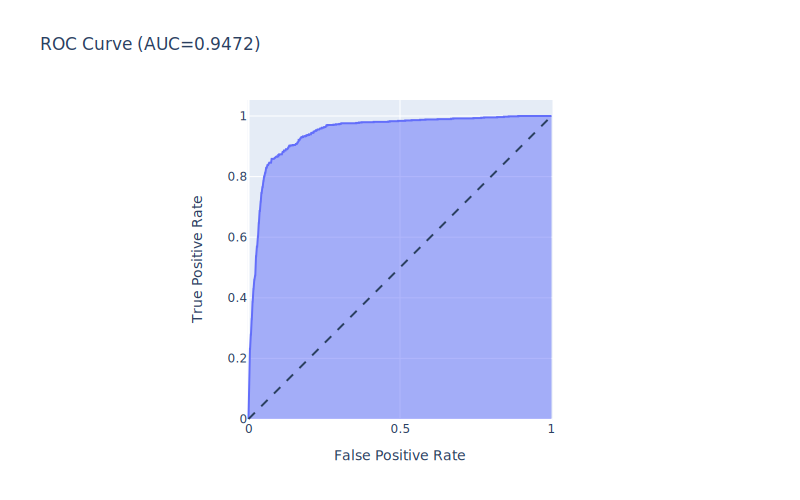

In [13]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

An AUC score of 0.88 is quite remarkable and it suggests that the model is quite good at predicting whether a project on Kickstarter will be successful or not. This model performed better than the logistic regression models.

In [14]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

In [15]:
# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.79, 0.81)]

fpr       tpr  threshold
184  0.049618  0.793615   0.515917
185  0.050095  0.793615   0.513528
186  0.050095  0.795895   0.511968
187  0.051050  0.795895   0.511324
188  0.051050  0.799316   0.510062
189  0.051527  0.799316   0.508657
190  0.051527  0.800456   0.508389
191  0.052481  0.800456   0.507243
192  0.052481  0.801596   0.506943

From the above table, it is safe to assume the threshold value of 0.5 for classifying the observations.

In [17]:
# Save the model
joblib.dump(grid_result, './../../data/models/svm.pkl')
joblib.dump(grid_result_poly, './../../data/models/svm_poly.pkl')

['./../../data/models/svm_poly.pkl']

## Model with oversample data

Continuing with the oversampled data.

In [18]:
# Load the data
df = pd.read_csv('./../../data/engineered_data_oversampled.csv')

In [19]:
# Drop the index column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

For this data also, only one set of parameters will be used for tuning. The parameters that will be used are:

|Parameter|Description|Values|
|--|--|--|
|C|Cost of SVM for determining the margin|$10^{-3}:1$|
|kernel|Type of kernel to be used|1. 'linear' for linear kernel <br>2. 'rbf' for radial basis function <br> 3. 'sigmoid' for logistic kernel| 

In [21]:
# Declare the SVM model
svm_clf = SVC(probability=True, class_weight='balanced')

# Declare the grid paramters to be searched
svm_params = dict(
    C = np.logspace(-3, 0, num=4),
    kernel = ['linear', 'rbf', 'sigmoid']
)

In [ ]:
# Declare the gridsearch object
grid_search = GridSearchCV(svm_clf, svm_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result = grid_search.fit(X_train, y_train)

```{warning}
Time required to run SVM with oversampled data: 552 mins.
```

### Inferencing

The best model on oversampled is given by:

In [32]:
# Get the best model parameters
print(f"Best score of {grid_result.best_score_} is achieved by using {grid_result.best_params_}")

Best score of 0.9582827048948805 is achieved by using {'C': 1.0, 'kernel': 'linear'}


In [33]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)[:, 1]

### Evaluation

The AUC ROC score for the model is:

In [34]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.9514918050788321


With the new oversampled data, there is a marginal improvement in the performance of the support vector machine algorithm.

Thus, to find the threshold for the optimum evaluation metric, thresholds with their corresponding TPR and FPR needs to be determined and can be found by:

In [35]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

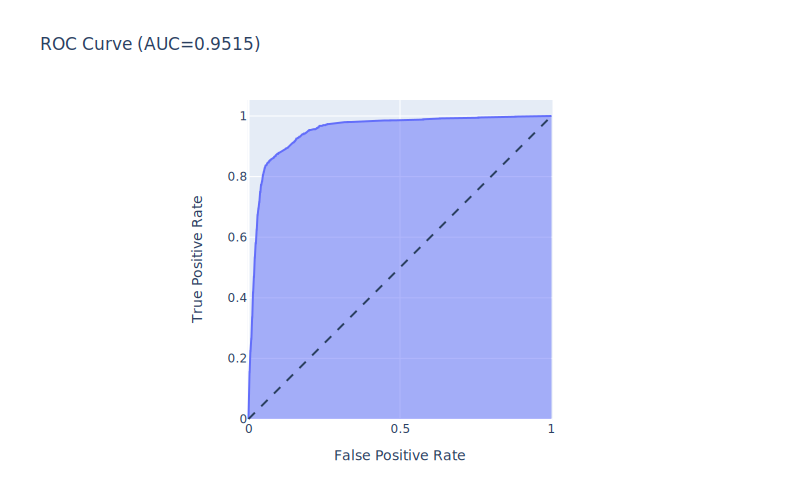

In [36]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [37]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

In [96]:
# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.89, 0.90)]

fpr       tpr  threshold
343  0.122782  0.891679   0.500000
344  0.123261  0.891679   0.494277
345  0.123261  0.892664   0.491941
346  0.124221  0.892664   0.490585
347  0.124221  0.893156   0.489900
348  0.125659  0.893156   0.488325
349  0.125659  0.893648   0.486883
350  0.126139  0.893648   0.486531
351  0.126139  0.894141   0.485656
352  0.127578  0.894141   0.485366
353  0.127578  0.895126   0.484574
354  0.129496  0.895126   0.479773
355  0.129496  0.895618   0.479133
356  0.129976  0.895618   0.478438
357  0.129976  0.896110   0.477416
358  0.130935  0.896110   0.476623
359  0.130935  0.896603   0.475434
360  0.131415  0.896603   0.474092
361  0.131415  0.897587   0.472469
362  0.131894  0.897587   0.471175
363  0.131894  0.899065   0.468694
364  0.132374  0.899065   0.468370

Since the threshold for the optimum TPR is near 0.5. The threshold that will be used is 0.5 i.e. the default will be used.

In [97]:
# Plot classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88      2085
         1.0       0.87      0.90      0.88      2031

    accuracy                           0.88      4116
   macro avg       0.88      0.88      0.88      4116
weighted avg       0.88      0.88      0.88      4116



The F1-score thus obtained is better than that of logistic regression and hence it can be concluded that SVM with linear kernel is btter in predicting the success of the Kickstarter Campaign.

In [40]:
# Save the model
joblib.dump(grid_result, './../../data/models/svm_oversample.pkl')

['./../../data/models/svm_oversample_poly.pkl']

## Principal Componanent Analysis

The time required to train the SVM algorithms is huge. The training time is the function of the number of observations and the number of columns. It is possible to reduce the number of features without losing much information. This can be achieved by using Principal Component Analysis (PCA).

To reduce the number of features using PCA, it is necessary to standardize the features.

In [48]:
# Standardize the data

# Declare the scaling object
standard_scaler = StandardScaler()

# Fit the scaling object
standard_scaler.fit(X_train)

# Transform the data using the scaled object
scaled_train = standard_scaler.transform(X_train)
scaled_test = standard_scaler.transform(X_test)

To find the optimum number of features to be retained, it is necessary to examine the information loss that can be tolerated. The information loss can be evaluated on the basis of varince. The maximum the variance, the lesser the information loss. To find the optimum number, PCA should on run on complete data.

In [53]:
# Declare PCA object to check the optimum number of components
experiment_pca = PCA(n_components=None)

In [54]:
# Use the PCA to fit the data
experiment_pca.fit(scaled_train)

PCA()

The PCA gives us the ratios of variances for the different numbers of components which signifies the percentage of information retained by that number of components.

Scree plot can be of great help for deciding on the number of components

In [65]:
# Store the results
experiment_pca_eigen_values = pd.DataFrame(experiment_pca.explained_variance_ratio_*100).reset_index()
experiment_pca_eigen_values.columns = ["Eigen Value Size", "Eigen Value Number"]

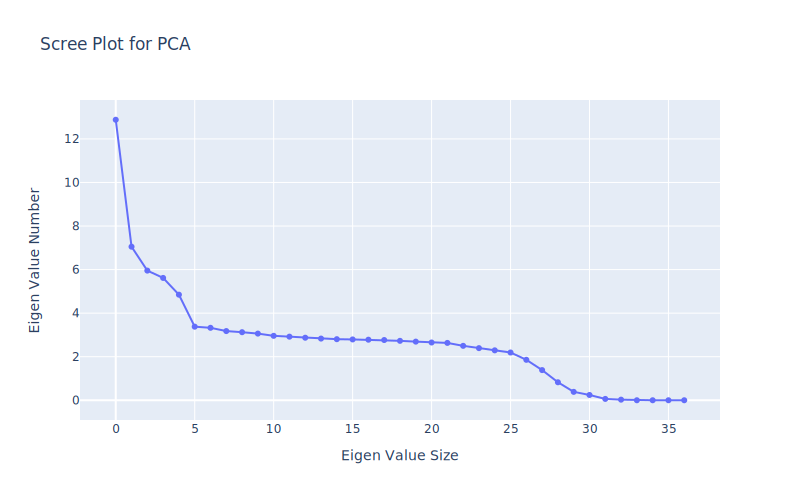

In [66]:
# Plot the scree plot
fig = px.line(experiment_pca_eigen_values, x='Eigen Value Size', y="Eigen Value Number", markers=True, title="Scree Plot for PCA")
fig.show()

There exist an elbow at 5 components in the scree plot but the variance explained by those many components may not be sufficient. Further evaluation is necessary for the variance explained.

In [67]:
# Find the cumulative variances across the components
exp_var = experiment_pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

In [74]:
# Store the cumulative results
exp_var_df = pd.DataFrame([exp_var, cum_exp_var]).T.reset_index()
exp_var_df.columns = ["Components", "Explained Variance", "Cumulative Explained Variance"]
exp_var_df.head(10)

Components  Explained Variance  Cumulative Explained Variance
0           0           12.880015                      12.880015
1           1            7.050662                      19.930677
2           2            5.953163                      25.883840
3           3            5.616665                      31.500505
4           4            4.847132                      36.347637
5           5            3.378421                      39.726058
6           6            3.326492                      43.052549
7           7            3.176691                      46.229240
8           8            3.124685                      49.353925
9           9            3.060913                      52.414839

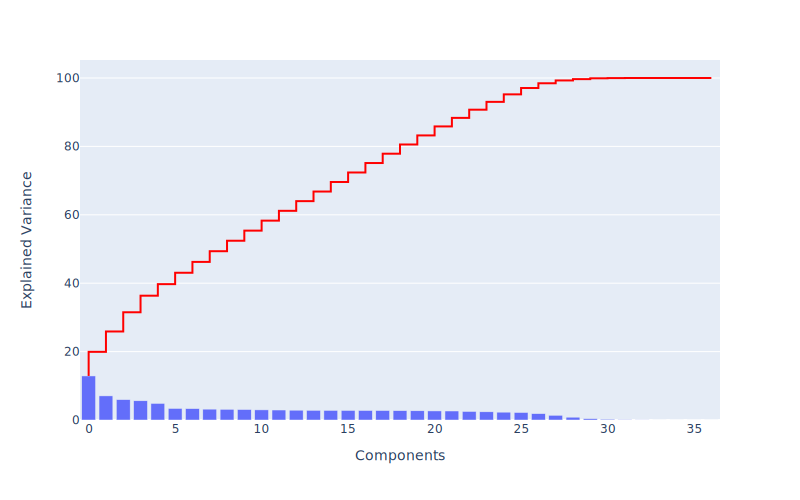

In [91]:
# Plot the cumulative variance
fig1 = px.bar(exp_var_df, x='Components', y='Explained Variance')
fig2 = px.line(exp_var_df, x='Components', y='Cumulative Explained Variance', text='Cumulative Explained Variance')
fig2.update_traces(mode="lines", line_shape="vh", line_color="red")
fig1.add_trace(fig2.data[0])
fig1.show()

Though an elbow exists at 5 components, those many components are too less to explain the variance in the data. In other words, 5 components will be able to retain a sufficient amount of information for building a model. More than 20 components are required to explain more than 85% of the variance. Hence, it will not be wise to use PCA to reduce the number of dimensions.